<a href="https://colab.research.google.com/github/caramelpopcornKHU/GIS_Project/blob/main/GEO_SOM_Seoul_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEO-SOM 알고리즘의 결과로 산출된 군집을 K-means 알고리즘과 Gap statistics를 사용하여 서울시 최종 군집 완성

In [ ]:
import os
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [ ]:
# 코드의 시각적 편의를 위해 함수를 utils.py에 넣어놓고 사용
import sys

util = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/'
!pip install util
sys.path.append(util)
from utils import *

ModuleNotFoundError: No module named 'utils'

In [ ]:
path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData'

In [ ]:
geo_som_seoul_cluster = gpd.read_file(os.path.join(path,'voronoi_seoul2.shp'), encoding='utf-8')

In [ ]:
geo_som_seoul_cluster['cluster'].unique()

array([337, 356, 339, 376, 319, 396, 378, 338, 377, 397, 398, 357, 395,
       379, 399, 358, 359])

In [ ]:
geo_som_seoul_cluster.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# GEO-SOM 알고리즘의 결과: 보로노이 폴리곤

GEO-SOM 알고리즘은 공간 정보와 데이터 특성을 함께 고려하여 클러스터링을 수행합니다.  
이를 기반으로 생성된 **보로노이 폴리곤**은 GEO-SOM 클러스터 결과를 공간적으로 시각화한 것입니다.

---

## 왜 centroid와 클러스터 중심점을 함께 사용하는가?

기존의 **K-means**는 **유클리디언 거리**를 기반으로 작동하기 때문에,  
공간 위치 `(x, y)`만으로는 클러스터 특성을 완전히 반영하기 어렵습니다.

따라서 아래 두 가지 정보를 함께 사용하면  
**데이터의 특성과 공간적 위치를 모두 고려한 클러스터링 분석**이 가능합니다:

- **보로노이 폴리곤의 중심점 (Centroid)**
  - `x`, `y`: 해당 지역의 **지리적 중심 좌표**

- **GEO-SOM으로 할당된 클러스터의 중심점**
  - `x′`, `y′`: 데이터 특성 공간에서의 **클러스터 중심 좌표**

---

## 예시 좌표 형식


- `x`, `y`  : 보로노이 폴리곤의 중심점 (지리 중심)
- `x′`, `y′`: GEO-SOM 클러스터 중심점 (속성 기반 중심)

이와 같이 4차원 좌표를 기반으로 K-means와 Gap Statistics를 적용하면,  
**지리적 유사성과 데이터 특성 유사성을 동시에 고려한 최적의 군집 수**를 도출할 수 있습니다.


4. 2차 군집 분석: K-Means + Gap Statistic

위 문제를 해결하기 위해 두 번째 군집화 단계로는 K-Means 알고리즘을 적용하였습니다.

K-Means는 유클리디언 거리 기반 알고리즘으로, 일반적으로 이상치에 민감하지만,서울시 내 건물 데이터는 극단적인 이상치가 적고 분포가 제한적이므로 K-Means 적용이 타당하다고 판단하였습니다.

클러스터링 입력:

각 건물 포인트의 좌표 (x, y)

GEO-SOM을 통해 할당된 클러스터의 중심좌표 (x’, y’)→ 총 4차원의 좌표 정보를 바탕으로 K-Means 클러스터링 수행

군집 수 결정:

Gap Statistic 기법을 사용하여 최적의 군집 수를 탐색하고 적용

결과:

GEO-SOM의 세분화된 군집을 K-Means를 통해 공간적으로 응집력 있는 군집들로 재구성

시각적으로 해석이 용이하며, 건물 물리정보 기반의 서울시 패턴을 효과적으로 요약 가능

In [ ]:
for i in range(len(geo_som_seoul_cluster['cluster'].unique())):
  condition_01 = geo_som_seoul_cluster['cluster'] == geo_som_seoul_cluster['cluster'].unique()[i]
  x01 = geo_som_seoul_cluster[condition_01]['geometry'].centroid.x.mean()
  y01 = geo_som_seoul_cluster[condition_01]['geometry'].centroid.y.mean()

  geo_som_seoul_cluster.loc[condition_01,'x01'] = x01
  geo_som_seoul_cluster.loc[condition_01,'y01'] = y01


In [ ]:
geo_som_seoul_cluster['x'] = geo_som_seoul_cluster.centroid.x
geo_som_seoul_cluster['y'] = geo_som_seoul_cluster.centroid.y

In [ ]:
X = geo_som_seoul_cluster[['x', 'y', 'x01', 'y01']].values

In [ ]:
k, gapdf = optimalK(X,maxClusters=15)
print('Optimal k is: ', k)

/content/drive/MyDrive/GIS_Project_GEO_SOM조/utils.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsdf = pd.concat([resultsdf, new_row], ignore_index=True)


Optimal k is:  14


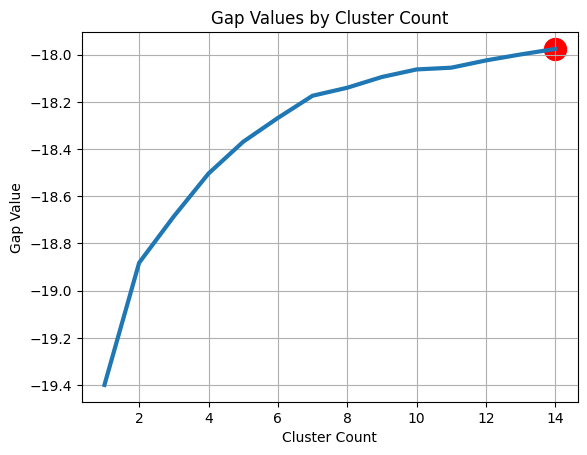

In [ ]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=14, random_state=42)
geo_som_seoul_cluster['merged_cluster'] = kmeans.fit_predict(X)

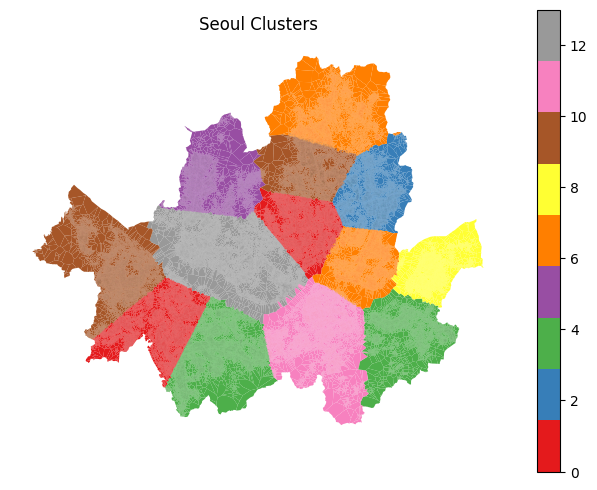

In [ ]:
geo_som_seoul_cluster.plot(column='merged_cluster', cmap='Set1', legend=True, figsize=(8,6))
plt.title("Seoul Clusters")
plt.axis('off')
plt.show()

In [ ]:
output_path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/kmean_seoul_14.shp'
geo_som_seoul_cluster.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')
print(f"Shapefile 저장 완료: {output_path}")

<ipython-input-12-ede124975f01>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_som_seoul_cluster.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')


Shapefile 저장 완료: /content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/kmean_seoul_14.shp


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'merged_cluster' to 'merged_clu'
  ogr_write(


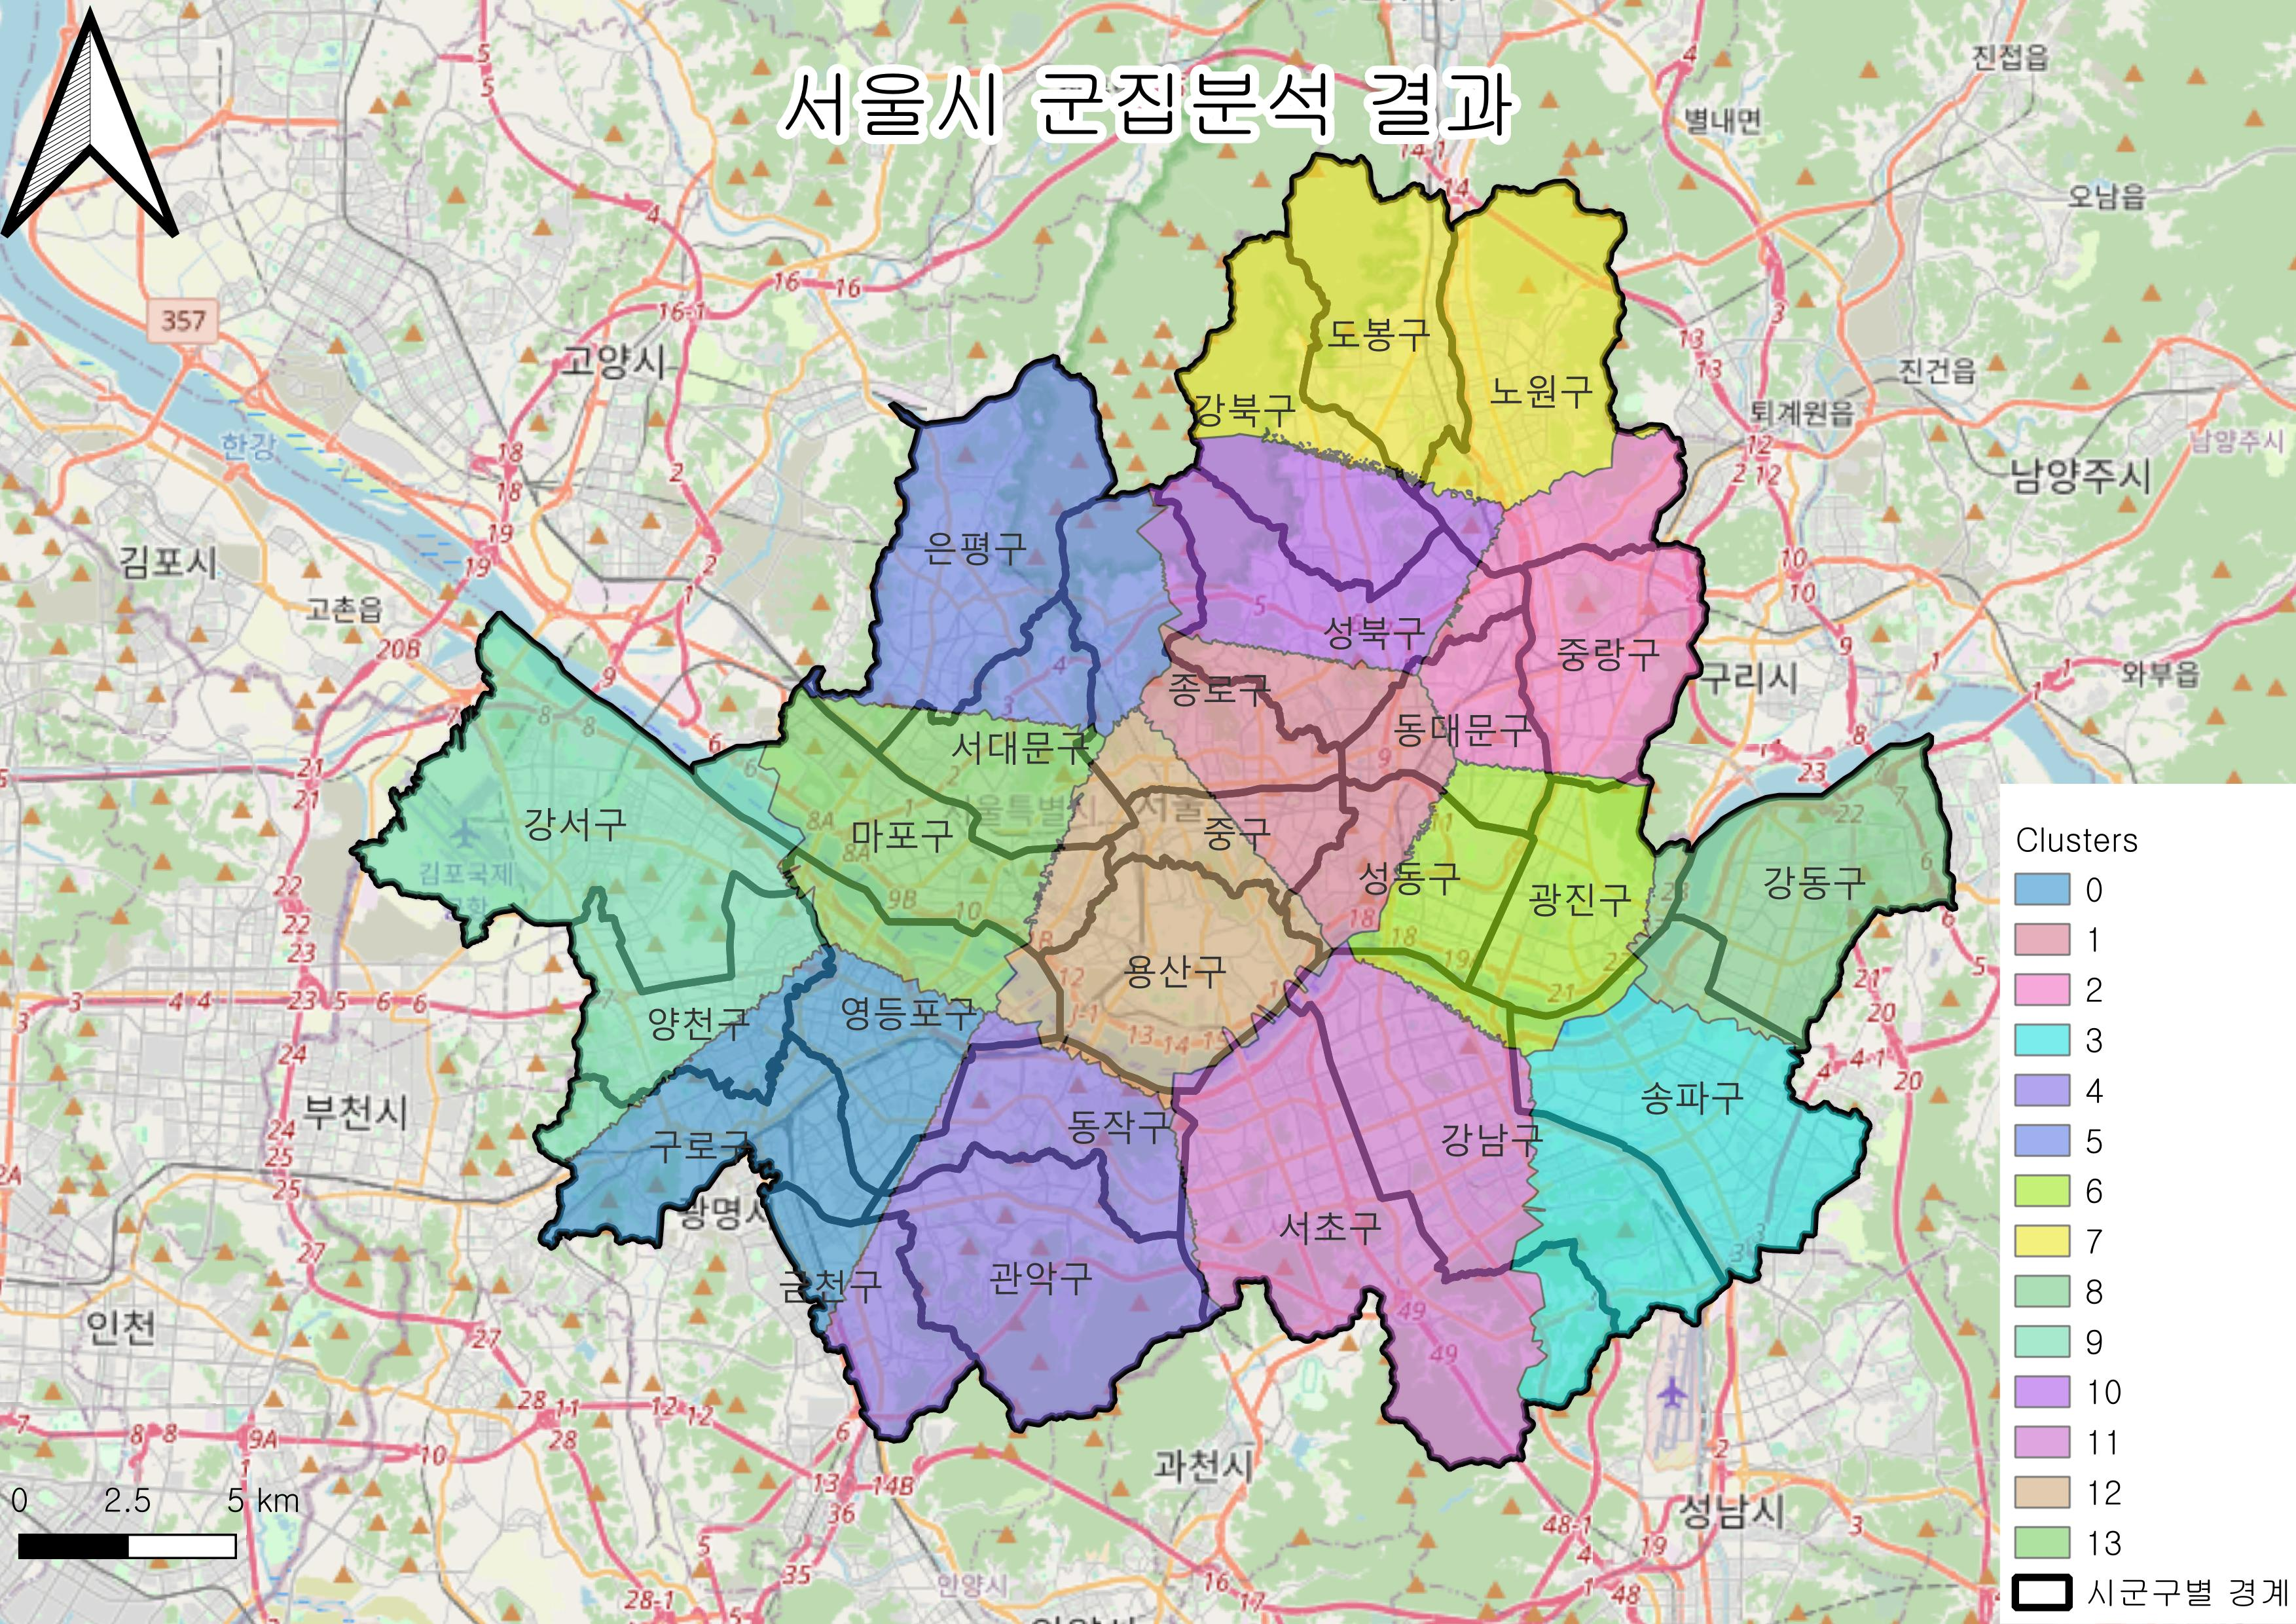

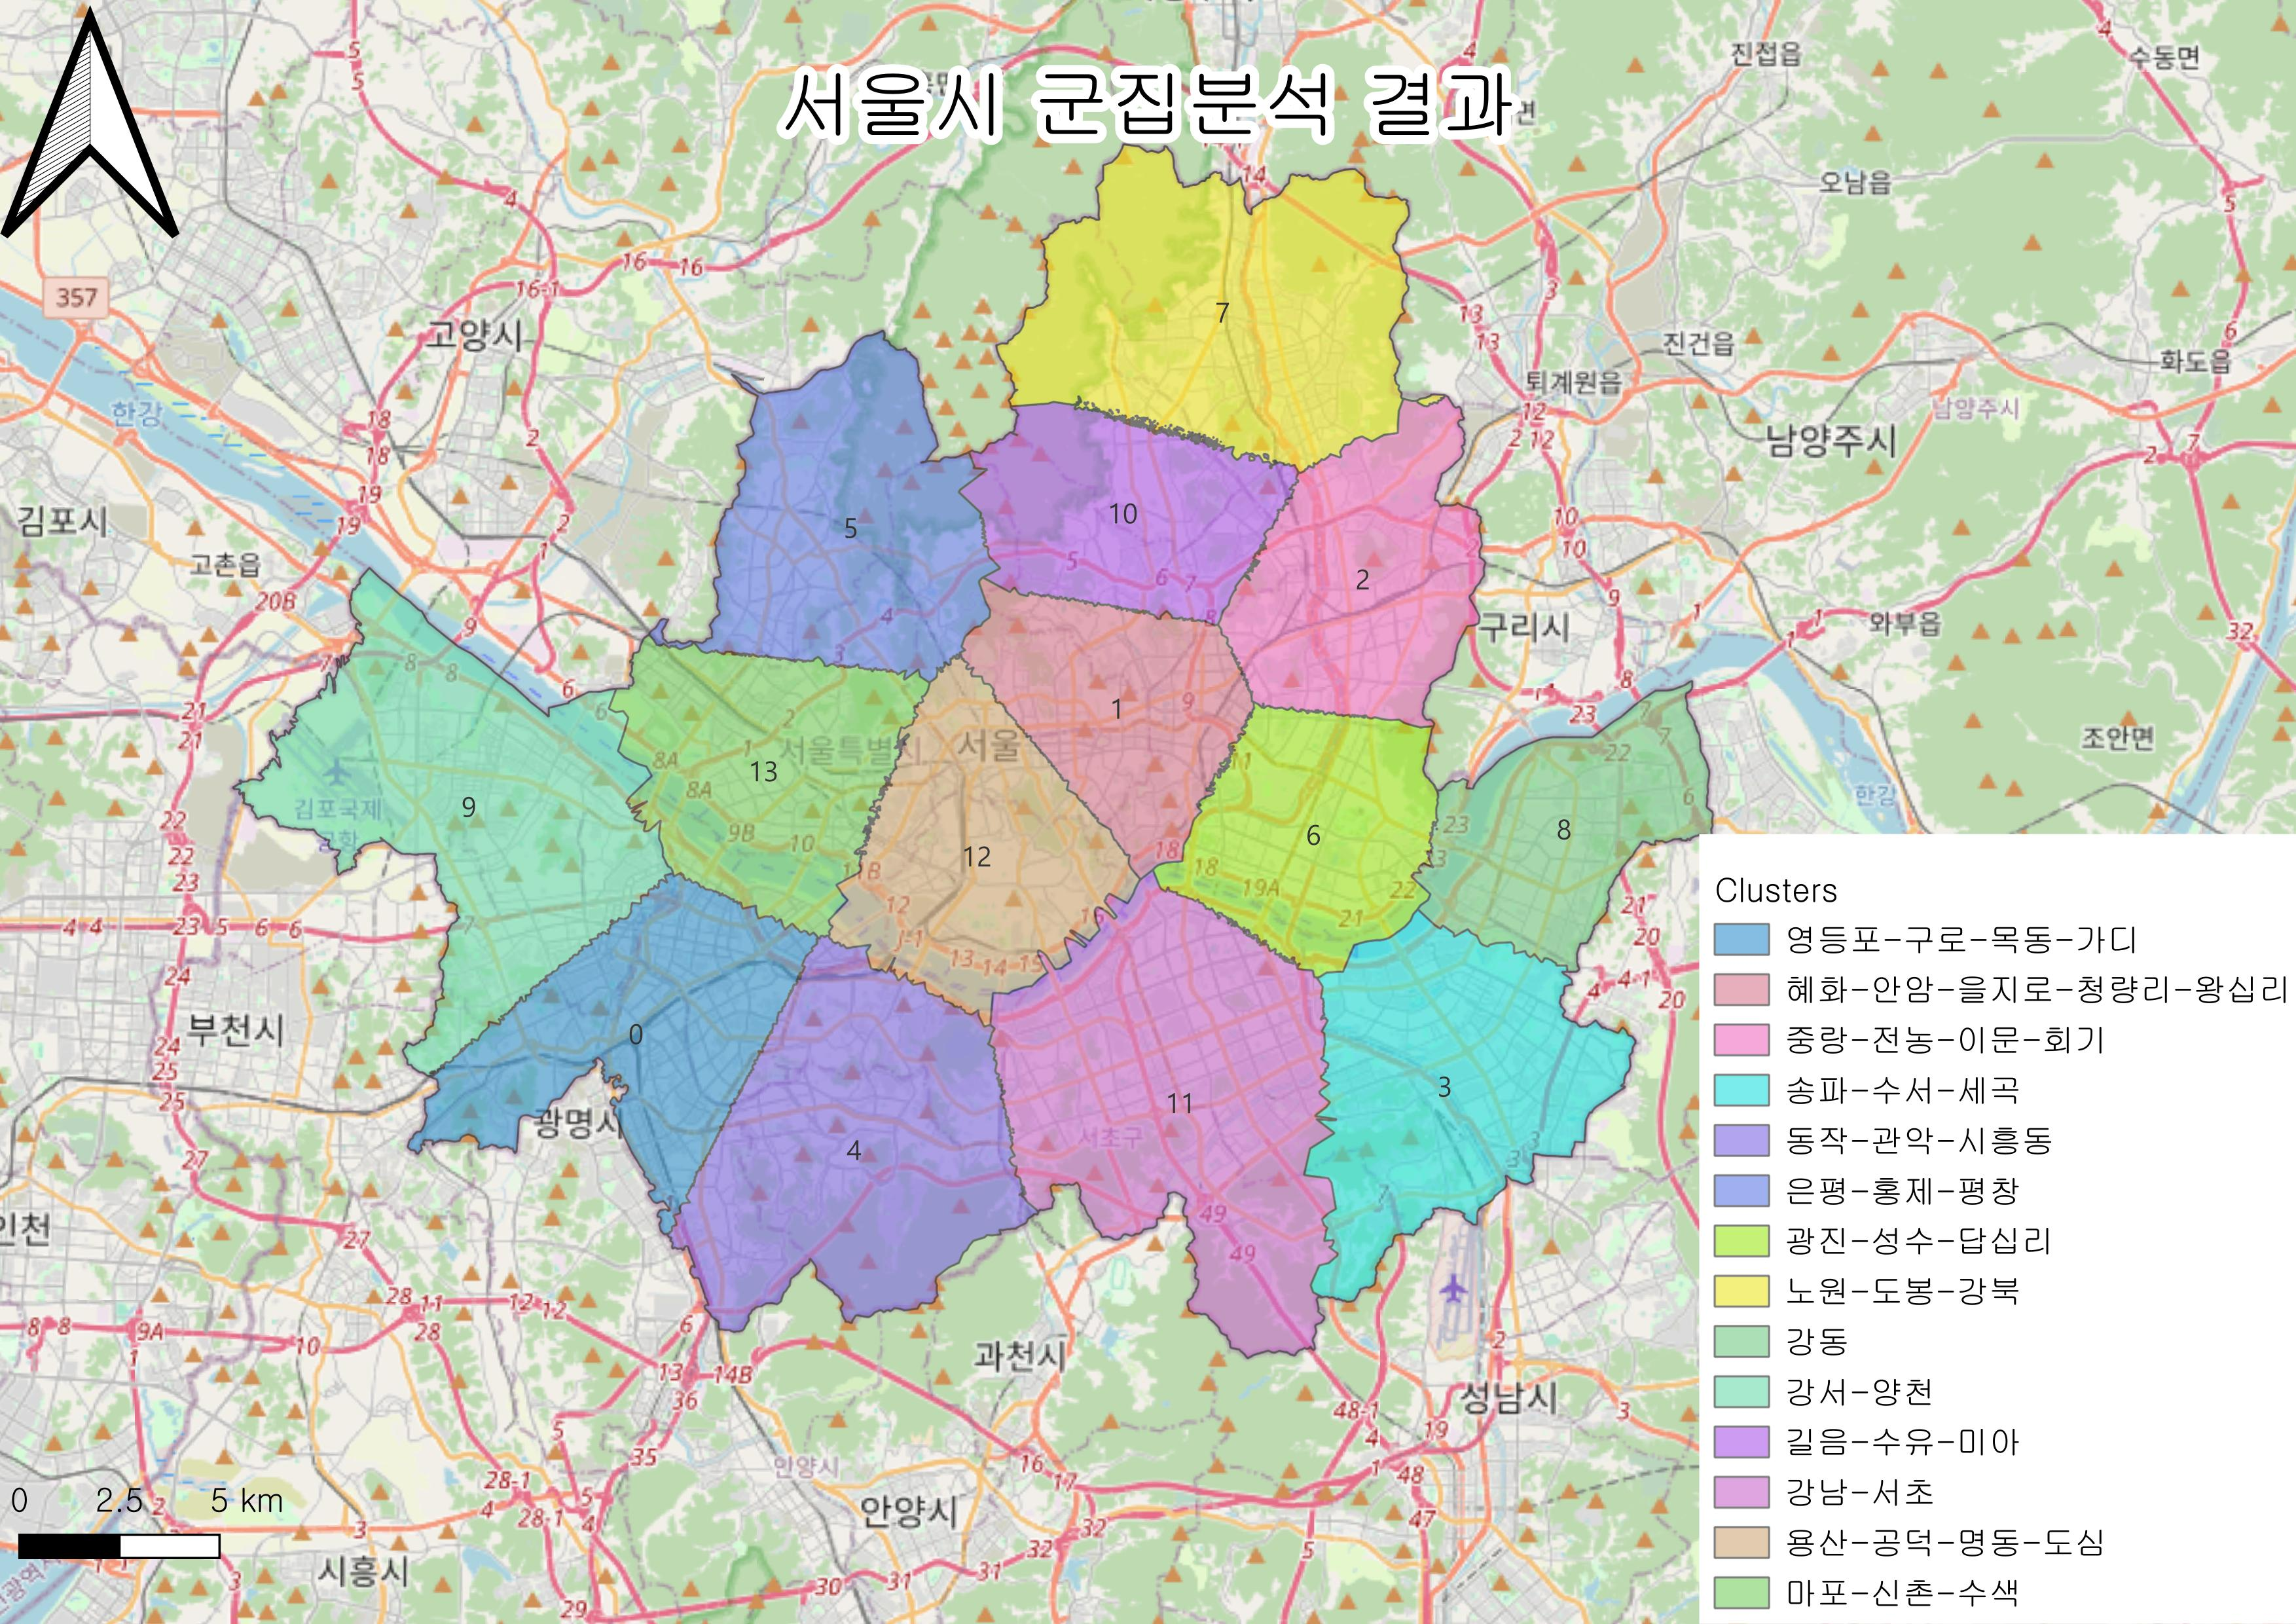

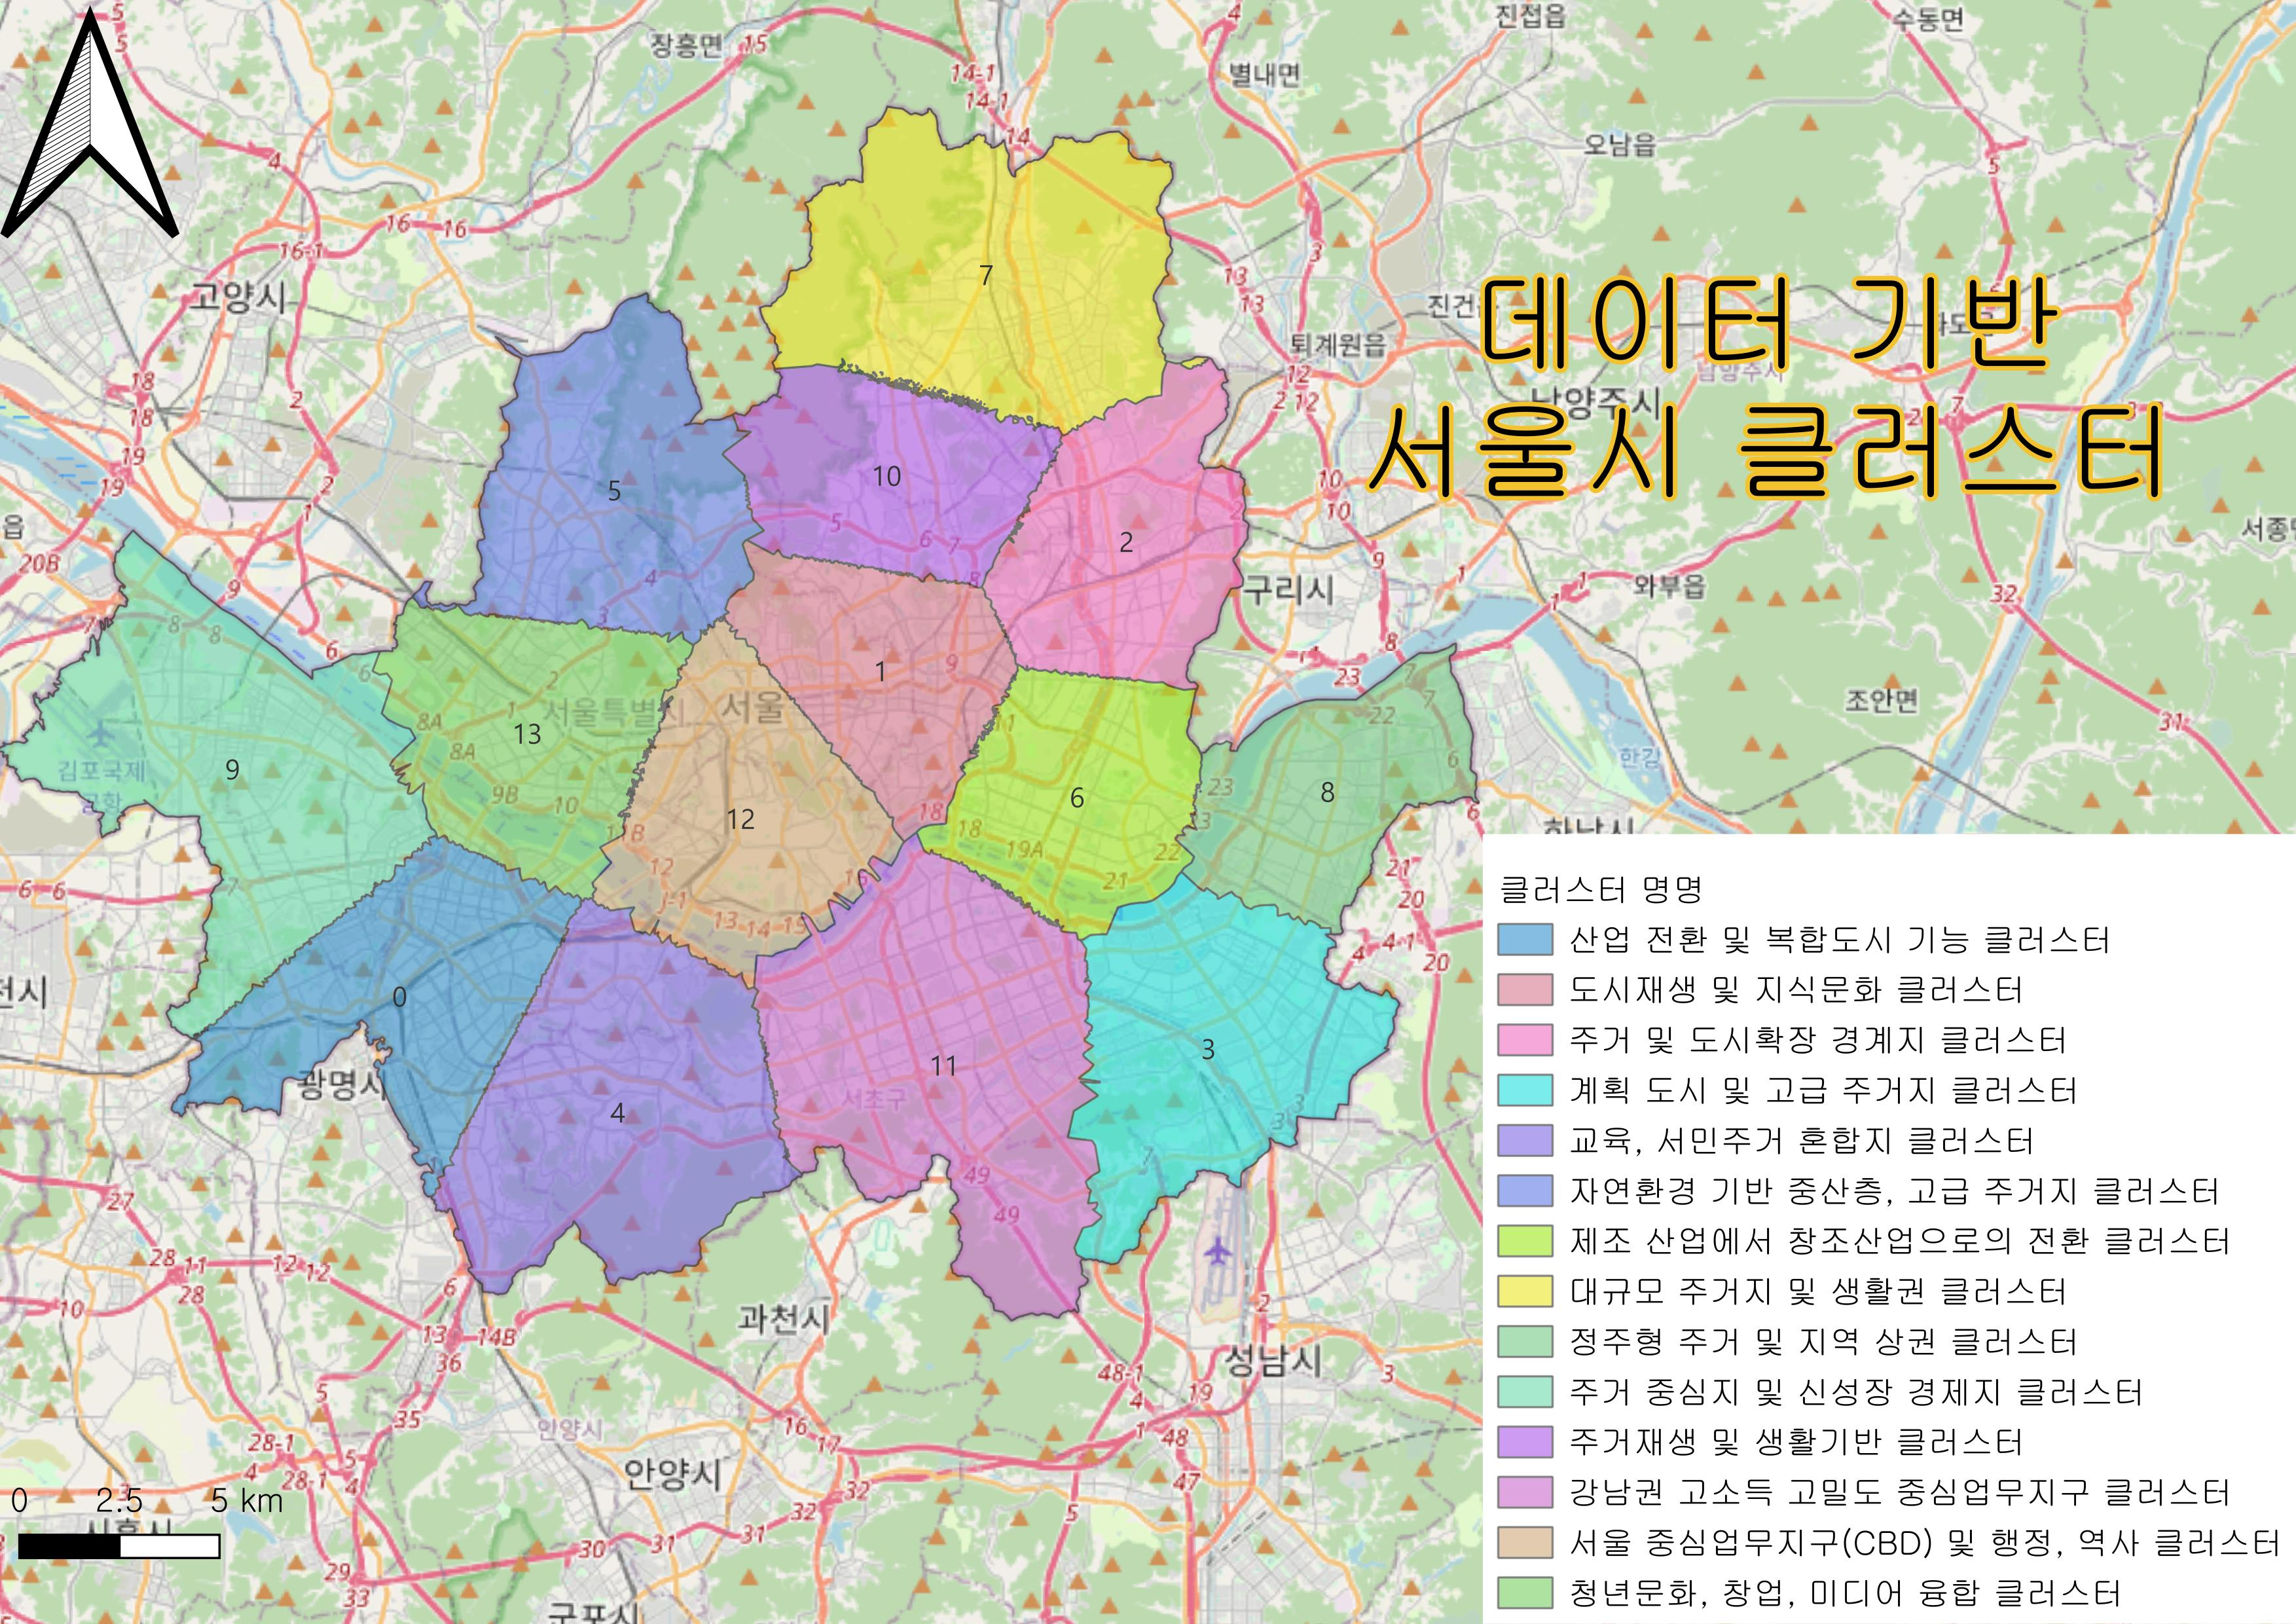